In [2]:
# pip install cvxpy pandas matplotlib tqdm

In [3]:
import cvxpy as cp
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

In [4]:
time_from = pd.Timestamp("now", tz="CET").floor("d")
time_to = pd.Timestamp("now", tz="CET").ceil("d")
idx = pd.date_range(start=time_from, end=time_to, freq="15min", inclusive="left")

/var/folders/60/3b6cs8g91cvg6lc0ptxbm3xw0000gn/T/ipykernel_34103/830955062.py:1: Pandas4Warning: 'd' is deprecated and will be removed in a future version, please use 'D' instead.
  time_from = pd.Timestamp("now", tz="CET").floor("d")
/var/folders/60/3b6cs8g91cvg6lc0ptxbm3xw0000gn/T/ipykernel_34103/830955062.py:2: Pandas4Warning: 'd' is deprecated and will be removed in a future version, please use 'D' instead.
  time_to = pd.Timestamp("now", tz="CET").ceil("d")


In [5]:
gb_eff = 0.98  # gas boiler heat efficiency
eb_eff = 0.98  # e-boiler heat efficiency
hp_cop = 4  # heat pump coefficient of performance
gas_price = 32  # EUR/MWht

gb_capacity = 120  # MWt
hp_capacity = 80  # MWt
eb_capacity = 40  # MWt

power_price = 0  # EUR/MWhe

<Axes: >

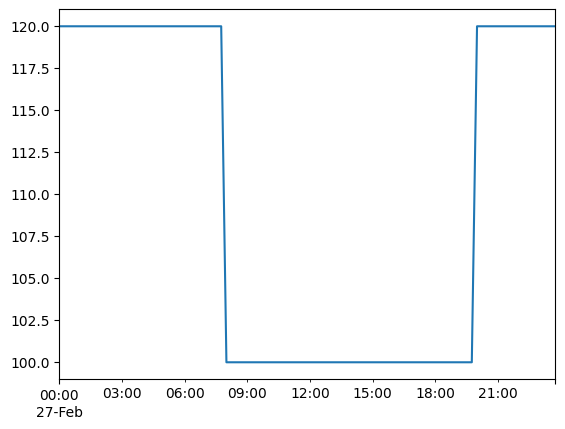

In [6]:
# heat demand is simulated to be higher during night time
heat_demand = pd.Series(100, index=idx)
heat_demand.loc[(heat_demand.index.hour >= 20) | (heat_demand.index.hour < 8)] = 120

heat_demand.plot()

In [7]:
# variables
hp_e_cons = cp.Variable(
    len(idx), name="hp_e_cons", nonneg=True
)  # heat pump electricity consumption
eb_e_cons = cp.Variable(
    len(idx), name="eb_e_cons", nonneg=True
)  # e boiler electricity consumption
gb_g_cons = cp.Variable(
    len(idx), name="gb_g_cons", nonneg=True
)  # gas boiler gas consumption

# parameters
max_power_cons = cp.Parameter(name="max_power_cons", value=1e9)

# auxiliary variables
total_e_cons = hp_e_cons + eb_e_cons
hp_h_prod = hp_e_cons * hp_cop
eb_h_prod = eb_eff * eb_e_cons
gb_h_prod = gb_eff * gb_g_cons
gas_cost = gas_price * gb_g_cons
power_cost = cp.multiply(power_price, hp_e_cons + eb_e_cons)
total_cost = power_cost + gas_cost

# constraints
constraints = [
    hp_h_prod + gb_h_prod + eb_h_prod == heat_demand.values,
    total_e_cons <= max_power_cons,
    hp_h_prod <= hp_capacity,
    gb_h_prod <= gb_capacity,
    eb_h_prod <= eb_capacity,
]

problem = cp.Problem(objective=cp.Minimize(cp.sum(total_cost)), constraints=constraints)
problem.solve()

np.float64(1.7431878418972864e-08)

In [8]:
marginal_heat_price = {}
marginal_power_price = {}

for v in tqdm(range(1, heat_demand.max())):
    max_power_cons.value = v + 1e-3
    problem.solve()
    marginal_heat_price[v] = -constraints[0].dual_value.round(4)  # shadow price of heat demand constraint
    marginal_power_price[v] = constraints[1].dual_value.round(4)  # shadow price of power consumption constraint

marginal_heat_price = pd.DataFrame(marginal_heat_price, index=idx)
marginal_power_price = pd.DataFrame(marginal_power_price, index=idx)

100%|██████████| 119/119 [00:00<00:00, 796.16it/s]


Text(0, 0.5, 'EUR/MWh')

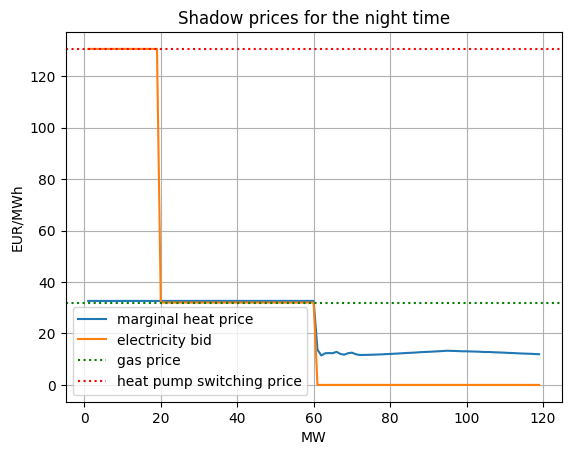

In [9]:
plt.title("Shadow prices for the night time")
marginal_heat_price.iloc[0].plot(label="marginal heat price")
marginal_power_price.iloc[0].plot(grid="on", label="electricity bid")
plt.axhline(gas_price, linestyle=":", color="green", label="gas price")
plt.axhline(
    gas_price * hp_cop / gb_eff,
    linestyle=":",
    color="red",
    label="heat pump switching price",
)
plt.legend()
plt.xlabel("MW")
plt.ylabel("EUR/MWh")

Text(0, 0.5, 'EUR/MWh')

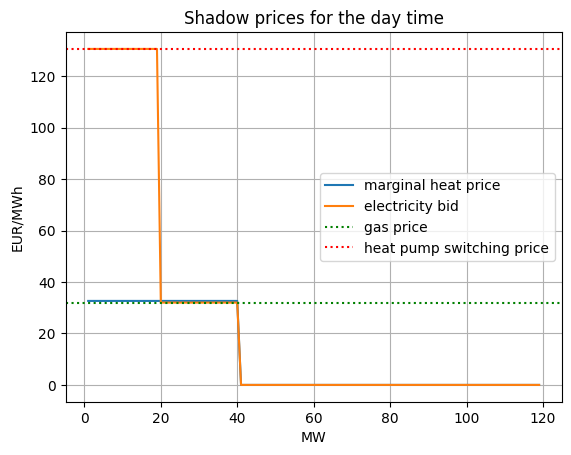

In [10]:
plt.title("Shadow prices for the day time")
marginal_heat_price.iloc[48].plot(label="marginal heat price")
marginal_power_price.iloc[48].plot(grid="on", label="electricity bid")
plt.axhline(gas_price, linestyle=":", color="green", label="gas price")
plt.axhline(
    gas_price * hp_cop / gb_eff,
    linestyle=":",
    color="red",
    label="heat pump switching price",
)
plt.legend()
plt.xlabel("MW")
plt.ylabel("EUR/MWh")